In [2]:
import torch
torch.cuda.empty_cache()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
df = pd.read_csv("C:/Users/roaam/Downloads/hyprid/Final_new_dataset/Final_dataset.csv")



In [5]:
df['status'].value_counts()

status
Normal                  16020
Depression              15086
Suicidal                10641
Anxiety                  3613
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [6]:
df.isnull().sum()

statement    0
status       0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51049 entries, 0 to 51048
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  51049 non-null  object
 1   status     51049 non-null  object
dtypes: object(2)
memory usage: 797.8+ KB


In [11]:
print(df.isnull().sum())

statement    0
status       0
dtype: int64


In [12]:
# df = df.drop(columns=['Unnamed: 0'])


In [13]:
df

,statement,status
0,"['oh', 'my', 'gosh']",Anxiety
1,"['trouble', 'sleep', 'confused', 'mind', 'rest...",Anxiety
2,"['all', 'wrong', 'back', 'off', 'dear', 'forwa...",Anxiety
3,"['I', 've', 'shift', 'my', 'focus', 'to', 'som...",Anxiety
4,"['I', 'm', 'restless', 'and', 'restless', 'its...",Anxiety
...,...,...
51044,"['anxiety', 'cause', 'faintness', 'when', 'sta...",Anxiety
51045,"['anxiety', 'heart', 'symptom', 'do', 'anyone'...",Anxiety
51046,"['travel', 'anxiety', 'hi', 'all', 'long', 'ti...",Anxiety
51047,"['fomo', 'from', 'thing', 'I', 'm', 'not', 'in...",Anxiety


In [14]:
from sklearn.utils import resample

In [ ]:
import pandas as pd


df_sample = df.sample(n=min(20000, len(df)), random_state=42)


class_counts = df_sample['status'].value_counts()
majority_size = class_counts.max()  
print(f"Target size for all classes: {majority_size}")


def resample_class(df_subset, target_size):
   
    if len(df_subset) == 0:
        return df_subset
    if len(df_subset) >= target_size:
        
        return df_subset.sample(n=target_size, random_state=42, replace=False)
    else:
        
        return resample(df_subset, replace=True, n_samples=target_size, random_state=42)

resampled_dfs = []
for status_val in class_counts.index:
    df_class = df_sample[df_sample['status'] == status_val]
    resampled_df = resample_class(df_class, majority_size)
    print(f"Status {status_val}: Original {len(df_class)} → Resampled {len(resampled_df)}")
    resampled_dfs.append(resampled_df)

df_balanced = pd.concat(resampled_dfs, axis=0).reset_index(drop=True)


data = df_balanced[['statement', 'status']]


Target size for all classes: 6353
Status Normal: Original 6353 → Resampled 6353
Status Depression: Original 5912 → Resampled 6353
Status Suicidal: Original 4101 → Resampled 6353
Status Anxiety: Original 1389 → Resampled 6353
Status Bipolar: Original 1019 → Resampled 6353
Status Stress: Original 886 → Resampled 6353
Status Personality disorder: Original 340 → Resampled 6353


In [16]:
print(data['status'].value_counts())
print(f"\nTotal samples: {len(data)}")


status
Normal                  6353
Depression              6353
Suicidal                6353
Anxiety                 6353
Bipolar                 6353
Stress                  6353
Personality disorder    6353
Name: count, dtype: int64

Total samples: 44471


In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['status_encoded'] = label_encoder.fit_transform(data['status'])


In [18]:
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Anxiety: 0
Bipolar: 1
Depression: 2
Normal: 3
Personality disorder: 4
Stress: 5
Suicidal: 6


In [19]:
train_df, valid_df = train_test_split(data, test_size=0.15, stratify=data["status_encoded"], random_state=42)

# Dataset / Tokenizer

In [20]:
MODEL_NAME = "microsoft/deberta-v3-base"

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 160


class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df["statement"].tolist()
        self.labels = df["status_encoded"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "status_encoded": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_loader = DataLoader(TextDataset(train_df), batch_size=256, shuffle=True)
valid_loader = DataLoader(TextDataset(valid_df), batch_size=256, shuffle=False)


# Model: BiLSTM + Attention on DeBERTa

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)  
        context = torch.sum(weights * x, dim=1)     
        return context


In [ ]:
class DeBERTa_BiLSTM_Attn(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-base", lstm_hidden=256, num_classes=7):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden = self.transformer.config.hidden_size

        for p in self.transformer.parameters():
            p.requires_grad = True

        self.lstm = nn.LSTM(
            input_size=hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.attn = AttentionLayer(lstm_hidden * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, input_ids, attention_mask,debug=False):
        with torch.no_grad():
            outputs = self.transformer(input_ids, attention_mask)
        seq = outputs.last_hidden_state 
        if debug:
            print("Transformer output:", seq.shape)

        lstm_out, _ = self.lstm(seq)
        if debug:
            print("LSTM output:", lstm_out.shape)
            
        attn_out = self.attn(lstm_out)
        if debug:
            print("Attention output:", attn_out.shape)

        x = self.dropout(attn_out)
        logits = self.fc(x)  
        if debug:
            print("Logits shape:", logits.shape)
        
        return logits


# Training Setup

In [ ]:
model = DeBERTa_BiLSTM_Attn().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4) # 2*10^-4
scaler = torch.cuda.amp.GradScaler()


# Training Loop (AMP Enabled)

In [24]:
def train_one_epoch(EPOCHS,debug=False):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for step,batch in enumerate(tqdm(train_loader, desc="Training")):
        inp = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["status_encoded"].to(device)
        
        debug_flag = debug and (EPOCHS == 0 and step == 0)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(inp, attn, debug=debug_flag)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss/total, correct/total  # هنا رجعنا train_loss و train_acc


# Validation with Accuracy

In [25]:
def validate(EPOCHS,debug=False):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for step, batch in enumerate(tqdm(valid_loader, desc="Validation")):
            inp = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["status_encoded"].to(device)
            
            debug_flag = debug and (EPOCHS == 0 and step == 0)
            
            logits = model(inp, attn,debug=debug_flag)
            loss = criterion(logits, labels)

            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss/total, correct/total


In [26]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [27]:

EPOCHS = 66

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    train_loss, train_acc = train_one_epoch(epoch,debug=True)
    val_loss, val_acc = validate(epoch,debug=True)


    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")





===== Epoch 1/66 =====


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Transformer output: torch.Size([256, 160, 768])
LSTM output: torch.Size([256, 160, 512])
Attention output: torch.Size([256, 512])
Logits shape: torch.Size([256, 7])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Transformer output: torch.Size([256, 160, 768])


Validation:   4%|▎         | 1/27 [00:03<01:40,  3.86s/it]

LSTM output: torch.Size([256, 160, 512])
Attention output: torch.Size([256, 512])
Logits shape: torch.Size([256, 7])


Validation: 100%|██████████| 27/27 [01:31<00:00,  3.39s/it]


Train Loss: 1.6717 | Train Acc: 0.3155
Val   Loss: 1.6110 | Val   Acc: 0.3488

===== Epoch 2/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 1.4830 | Train Acc: 0.4214
Val   Loss: 1.5189 | Val   Acc: 0.4136

===== Epoch 3/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.44s/it]


Train Loss: 1.3477 | Train Acc: 0.4817
Val   Loss: 1.5033 | Val   Acc: 0.4307

===== Epoch 4/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 1.2310 | Train Acc: 0.5342
Val   Loss: 1.1763 | Val   Acc: 0.5512

===== Epoch 5/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 1.1461 | Train Acc: 0.5678
Val   Loss: 1.1832 | Val   Acc: 0.5465

===== Epoch 6/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.44s/it]


Train Loss: 1.0676 | Train Acc: 0.6010
Val   Loss: 1.0736 | Val   Acc: 0.6055

===== Epoch 7/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 1.0016 | Train Acc: 0.6228
Val   Loss: 1.0036 | Val   Acc: 0.6248

===== Epoch 8/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 0.9280 | Train Acc: 0.6561
Val   Loss: 0.9244 | Val   Acc: 0.6594

===== Epoch 9/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 0.8785 | Train Acc: 0.6743
Val   Loss: 0.8713 | Val   Acc: 0.6753

===== Epoch 10/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.8410 | Train Acc: 0.6878
Val   Loss: 0.7909 | Val   Acc: 0.7041

===== Epoch 11/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.7951 | Train Acc: 0.7049
Val   Loss: 0.8070 | Val   Acc: 0.7102

===== Epoch 12/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.7594 | Train Acc: 0.7200
Val   Loss: 0.7427 | Val   Acc: 0.7288

===== Epoch 13/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.7199 | Train Acc: 0.7336
Val   Loss: 0.6806 | Val   Acc: 0.7516

===== Epoch 14/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.6786 | Train Acc: 0.7484
Val   Loss: 0.6114 | Val   Acc: 0.7750

===== Epoch 15/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.6527 | Train Acc: 0.7575
Val   Loss: 0.6300 | Val   Acc: 0.7617

===== Epoch 16/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.6256 | Train Acc: 0.7646
Val   Loss: 0.6036 | Val   Acc: 0.7748

===== Epoch 17/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.6031 | Train Acc: 0.7745
Val   Loss: 0.5937 | Val   Acc: 0.7781

===== Epoch 18/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.5813 | Train Acc: 0.7819
Val   Loss: 0.5671 | Val   Acc: 0.7831

===== Epoch 19/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.5609 | Train Acc: 0.7892
Val   Loss: 0.5530 | Val   Acc: 0.7925

===== Epoch 20/66 =====


Validation: 100%|██████████| 27/27 [01:31<00:00,  3.41s/it]


Train Loss: 0.5513 | Train Acc: 0.7895
Val   Loss: 0.5224 | Val   Acc: 0.8029

===== Epoch 21/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.5255 | Train Acc: 0.8030
Val   Loss: 0.4968 | Val   Acc: 0.8134

===== Epoch 22/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.5062 | Train Acc: 0.8067
Val   Loss: 0.4914 | Val   Acc: 0.8129

===== Epoch 23/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.4922 | Train Acc: 0.8135
Val   Loss: 0.4605 | Val   Acc: 0.8221

===== Epoch 24/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 0.4813 | Train Acc: 0.8202
Val   Loss: 0.5092 | Val   Acc: 0.8074

===== Epoch 25/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.4549 | Train Acc: 0.8262
Val   Loss: 0.4472 | Val   Acc: 0.8270

===== Epoch 26/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.4471 | Train Acc: 0.8310
Val   Loss: 0.4860 | Val   Acc: 0.8132

===== Epoch 27/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.4318 | Train Acc: 0.8341
Val   Loss: 0.4466 | Val   Acc: 0.8300

===== Epoch 28/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.4222 | Train Acc: 0.8392
Val   Loss: 0.4131 | Val   Acc: 0.8365

===== Epoch 29/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.4063 | Train Acc: 0.8456
Val   Loss: 0.4003 | Val   Acc: 0.8477

===== Epoch 30/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.3931 | Train Acc: 0.8514
Val   Loss: 0.4128 | Val   Acc: 0.8414

===== Epoch 31/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 0.3915 | Train Acc: 0.8507
Val   Loss: 0.3817 | Val   Acc: 0.8609

===== Epoch 32/66 =====


Validation: 100%|██████████| 27/27 [01:31<00:00,  3.41s/it]


Train Loss: 0.3777 | Train Acc: 0.8546
Val   Loss: 0.4528 | Val   Acc: 0.8312

===== Epoch 33/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.3719 | Train Acc: 0.8577
Val   Loss: 0.3926 | Val   Acc: 0.8541

===== Epoch 34/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.3524 | Train Acc: 0.8639
Val   Loss: 0.3627 | Val   Acc: 0.8619

===== Epoch 35/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.3441 | Train Acc: 0.8681
Val   Loss: 0.3841 | Val   Acc: 0.8537

===== Epoch 36/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.3349 | Train Acc: 0.8703
Val   Loss: 0.3616 | Val   Acc: 0.8603

===== Epoch 37/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 0.3256 | Train Acc: 0.8755
Val   Loss: 0.3664 | Val   Acc: 0.8684

===== Epoch 38/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.3199 | Train Acc: 0.8770
Val   Loss: 0.3371 | Val   Acc: 0.8780

===== Epoch 39/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.3110 | Train Acc: 0.8810
Val   Loss: 0.3393 | Val   Acc: 0.8727

===== Epoch 40/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.3088 | Train Acc: 0.8803
Val   Loss: 0.3560 | Val   Acc: 0.8702

===== Epoch 41/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2988 | Train Acc: 0.8866
Val   Loss: 0.3369 | Val   Acc: 0.8708

===== Epoch 42/66 =====


Validation: 100%|██████████| 27/27 [01:31<00:00,  3.41s/it]


Train Loss: 0.2915 | Train Acc: 0.8892
Val   Loss: 0.3210 | Val   Acc: 0.8732

===== Epoch 43/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2814 | Train Acc: 0.8913
Val   Loss: 0.3099 | Val   Acc: 0.8847

===== Epoch 44/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2807 | Train Acc: 0.8919
Val   Loss: 0.3320 | Val   Acc: 0.8813

===== Epoch 45/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2804 | Train Acc: 0.8931
Val   Loss: 0.3231 | Val   Acc: 0.8807

===== Epoch 46/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.2706 | Train Acc: 0.8961
Val   Loss: 0.2912 | Val   Acc: 0.8933

===== Epoch 47/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.2639 | Train Acc: 0.8981
Val   Loss: 0.3434 | Val   Acc: 0.8756

===== Epoch 48/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.2552 | Train Acc: 0.9033
Val   Loss: 0.2957 | Val   Acc: 0.8892

===== Epoch 49/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2516 | Train Acc: 0.9012
Val   Loss: 0.3136 | Val   Acc: 0.8813

===== Epoch 50/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2551 | Train Acc: 0.9024
Val   Loss: 0.2981 | Val   Acc: 0.8868

===== Epoch 51/66 =====


Validation: 100%|██████████| 27/27 [01:31<00:00,  3.40s/it]


Train Loss: 0.2394 | Train Acc: 0.9079
Val   Loss: 0.2983 | Val   Acc: 0.8901

===== Epoch 52/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2366 | Train Acc: 0.9095
Val   Loss: 0.2743 | Val   Acc: 0.8991

===== Epoch 53/66 =====


Validation: 100%|██████████| 27/27 [01:31<00:00,  3.41s/it]


Train Loss: 0.2339 | Train Acc: 0.9106
Val   Loss: 0.2825 | Val   Acc: 0.8996

===== Epoch 54/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2320 | Train Acc: 0.9112
Val   Loss: 0.2655 | Val   Acc: 0.9042

===== Epoch 55/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.2259 | Train Acc: 0.9152
Val   Loss: 0.2770 | Val   Acc: 0.8990

===== Epoch 56/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2185 | Train Acc: 0.9159
Val   Loss: 0.2684 | Val   Acc: 0.9060

===== Epoch 57/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2194 | Train Acc: 0.9169
Val   Loss: 0.2689 | Val   Acc: 0.9024

===== Epoch 58/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.2103 | Train Acc: 0.9196
Val   Loss: 0.3083 | Val   Acc: 0.8924

===== Epoch 59/66 =====


Validation: 100%|██████████| 27/27 [01:31<00:00,  3.40s/it]


Train Loss: 0.2104 | Train Acc: 0.9206
Val   Loss: 0.2709 | Val   Acc: 0.9033

===== Epoch 60/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.1997 | Train Acc: 0.9253
Val   Loss: 0.2825 | Val   Acc: 0.9027

===== Epoch 61/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.1956 | Train Acc: 0.9269
Val   Loss: 0.2785 | Val   Acc: 0.9053

===== Epoch 62/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.43s/it]


Train Loss: 0.1972 | Train Acc: 0.9256
Val   Loss: 0.2672 | Val   Acc: 0.9033

===== Epoch 63/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.1949 | Train Acc: 0.9271
Val   Loss: 0.2788 | Val   Acc: 0.9029

===== Epoch 64/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


Train Loss: 0.1907 | Train Acc: 0.9290
Val   Loss: 0.2809 | Val   Acc: 0.9017

===== Epoch 65/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.42s/it]


Train Loss: 0.1893 | Train Acc: 0.9275
Val   Loss: 0.2677 | Val   Acc: 0.9110

===== Epoch 66/66 =====


Validation: 100%|██████████| 27/27 [01:32<00:00,  3.41s/it]

Train Loss: 0.1830 | Train Acc: 0.9313
Val   Loss: 0.2561 | Val   Acc: 0.9108


# Confusion Matrix + Classification Report

In [28]:
label2id = {
    "Normal":0,
    "Depression":1,
    "Suicidal":2,
    "Anxiety":3,
    "Bi-Polar":4,
    "Stress":5,
    "Personality Disorder":6
}

In [29]:
target_names = list(label2id.keys())
target_names

['Normal',
 'Depression',
 'Suicidal',
 'Anxiety',
 'Bi-Polar',
 'Stress',
 'Personality Disorder']


Classification Report:
                      precision    recall  f1-score   support

              Normal       0.97      0.97      0.97       953
          Depression       0.97      0.99      0.98       953
            Suicidal       0.76      0.76      0.76       953
             Anxiety       0.95      0.85      0.90       953
            Bi-Polar       0.99      1.00      1.00       953
              Stress       0.96      0.99      0.97       953
Personality Disorder       0.78      0.82      0.80       953

            accuracy                           0.91      6671
           macro avg       0.91      0.91      0.91      6671
        weighted avg       0.91      0.91      0.91      6671



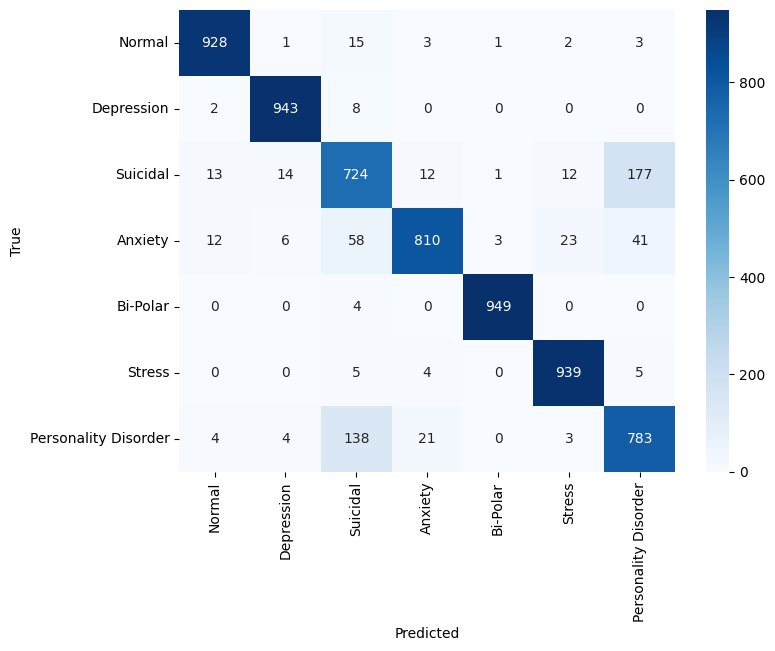

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

def full_metrics():
    model.eval()
    preds_all, labels_all = [], []

    with torch.no_grad():
        for batch in valid_loader:
            inp = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["status_encoded"].to(device)

            logits = model(inp, attn)
            preds = logits.argmax(1)

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(labels_all, preds_all, target_names=list(label2id.keys())))

    cm = confusion_matrix(labels_all, preds_all)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(label2id.keys()),
                yticklabels=list(label2id.keys()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


full_metrics()


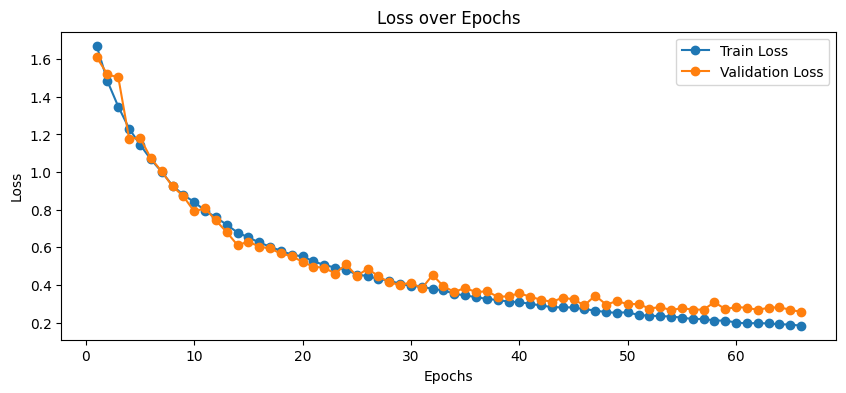

In [31]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10,4))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()



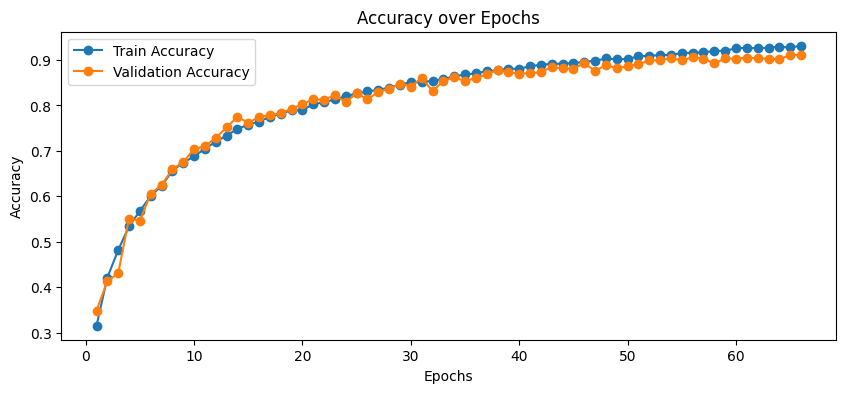

In [32]:

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(range(1, EPOCHS+1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, EPOCHS+1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

In [ ]:


import pickle

torch.save(model.state_dict(), "model_weights.pth")
torch.save(model, "deberta_full.pth")

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [ ]:

tokenizer.save_pretrained("./deberta_model")

('./deberta_model\\tokenizer_config.json',
 './deberta_model\\special_tokens_map.json',
 './deberta_model\\spm.model',
 './deberta_model\\added_tokens.json',
 './deberta_model\\tokenizer.json')

In [ ]:
# streamlit
# torch
# transformers
# numpy
# scikit-learn
# speechrecognition
# pyaudio
# # pip install pipwin
# # pipwin install pyaudio